**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

/tmp/ipykernel_1372974/900461155.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None
2023-03-23 20:16:41.530951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
def read_in_data(root: str):
    X = sorted(glob(f'{root}/images/*.tif'))
    Y = sorted(glob(f'{root}/masks/*.tif'))
    assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
    X = list(map(imread,X))
    Y = list(map(imread,Y))
    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
        sys.stdout.flush()
    X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
    Y = [fill_label_holes(y) for y in tqdm(Y)]
    return X, Y

In [3]:
X_trn, Y_trn = read_in_data("data/lizard/train")
X_val, Y_val = read_in_data("data/lizard/test")

Normalizing image channels independently.


100%|██████████| 710/710 [00:00<00:00, 1404.42it/s]


Normalizing image channels independently.


100%|██████████| 174/174 [00:00<00:00, 1601.84it/s]


In [4]:
print(f"number of images: {len(X_trn) + len(X_val)}")
print(f"- training      : {len(X_trn)}")
print(f"- validation    : {len(X_val)}")

number of images: 884
- training      : 710
- validation    : 174


In [5]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


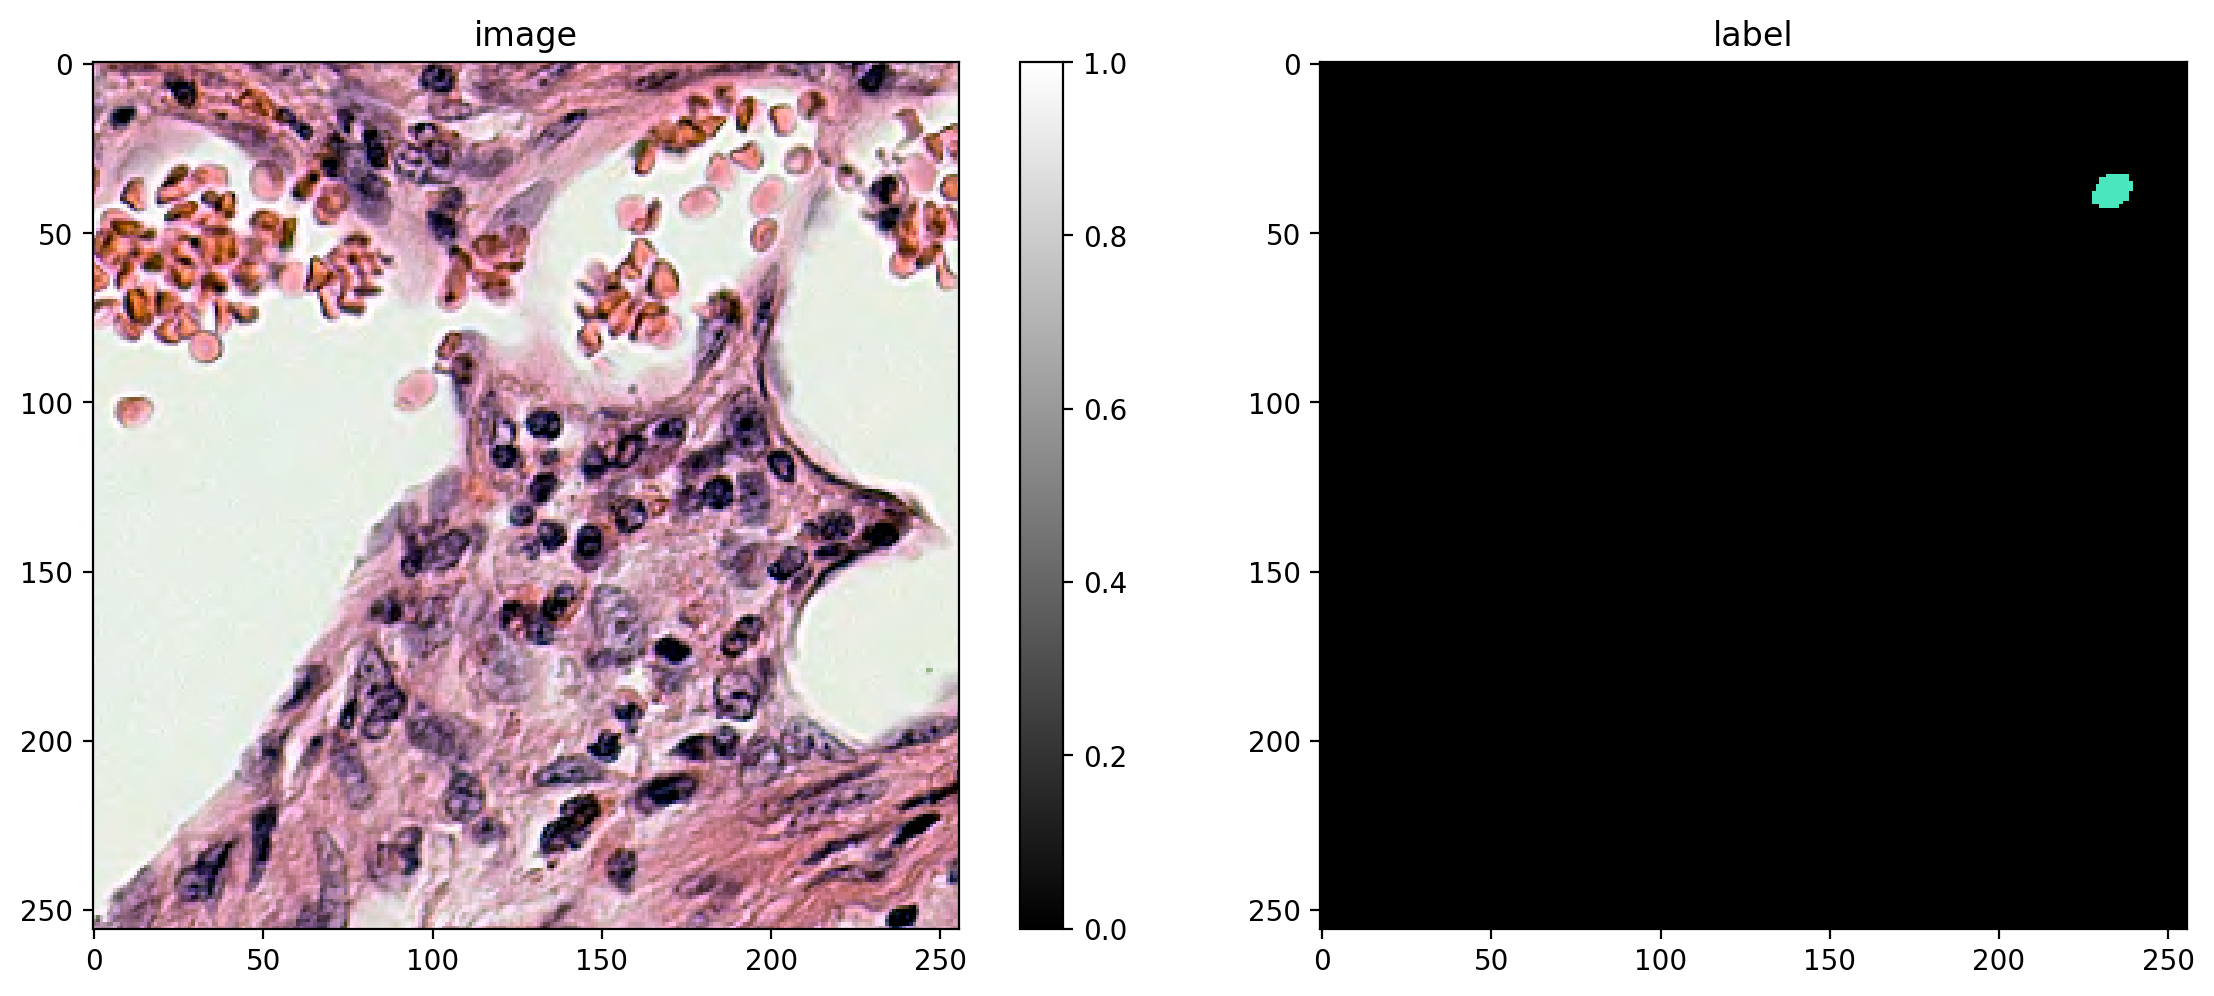

In [6]:
i = min(9, len(X_trn)-1)
img, lbl = X_trn[i], Y_trn[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [7]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [8]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = False,
    n_channel_in = 3,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [9]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [10]:
model = StarDist2D(conf, name='stardist', basedir='models')

base_model.py (149): output path for model already exists, files may be overwritten: /dss/dsshome1/09/ge59gew2/stardist/examples/2D/models/stardist
2023-03-23 20:16:51.094034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18372 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [11]:
median_size = calculate_extents(list(Y_trn), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2023-03-23 20:16:52.169869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


1/1 [==============================] - 0s 22ms/step
median object size:      [10. 10.]
network field of view :  [94 94]


2023-03-23 20:16:52.710602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [12]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


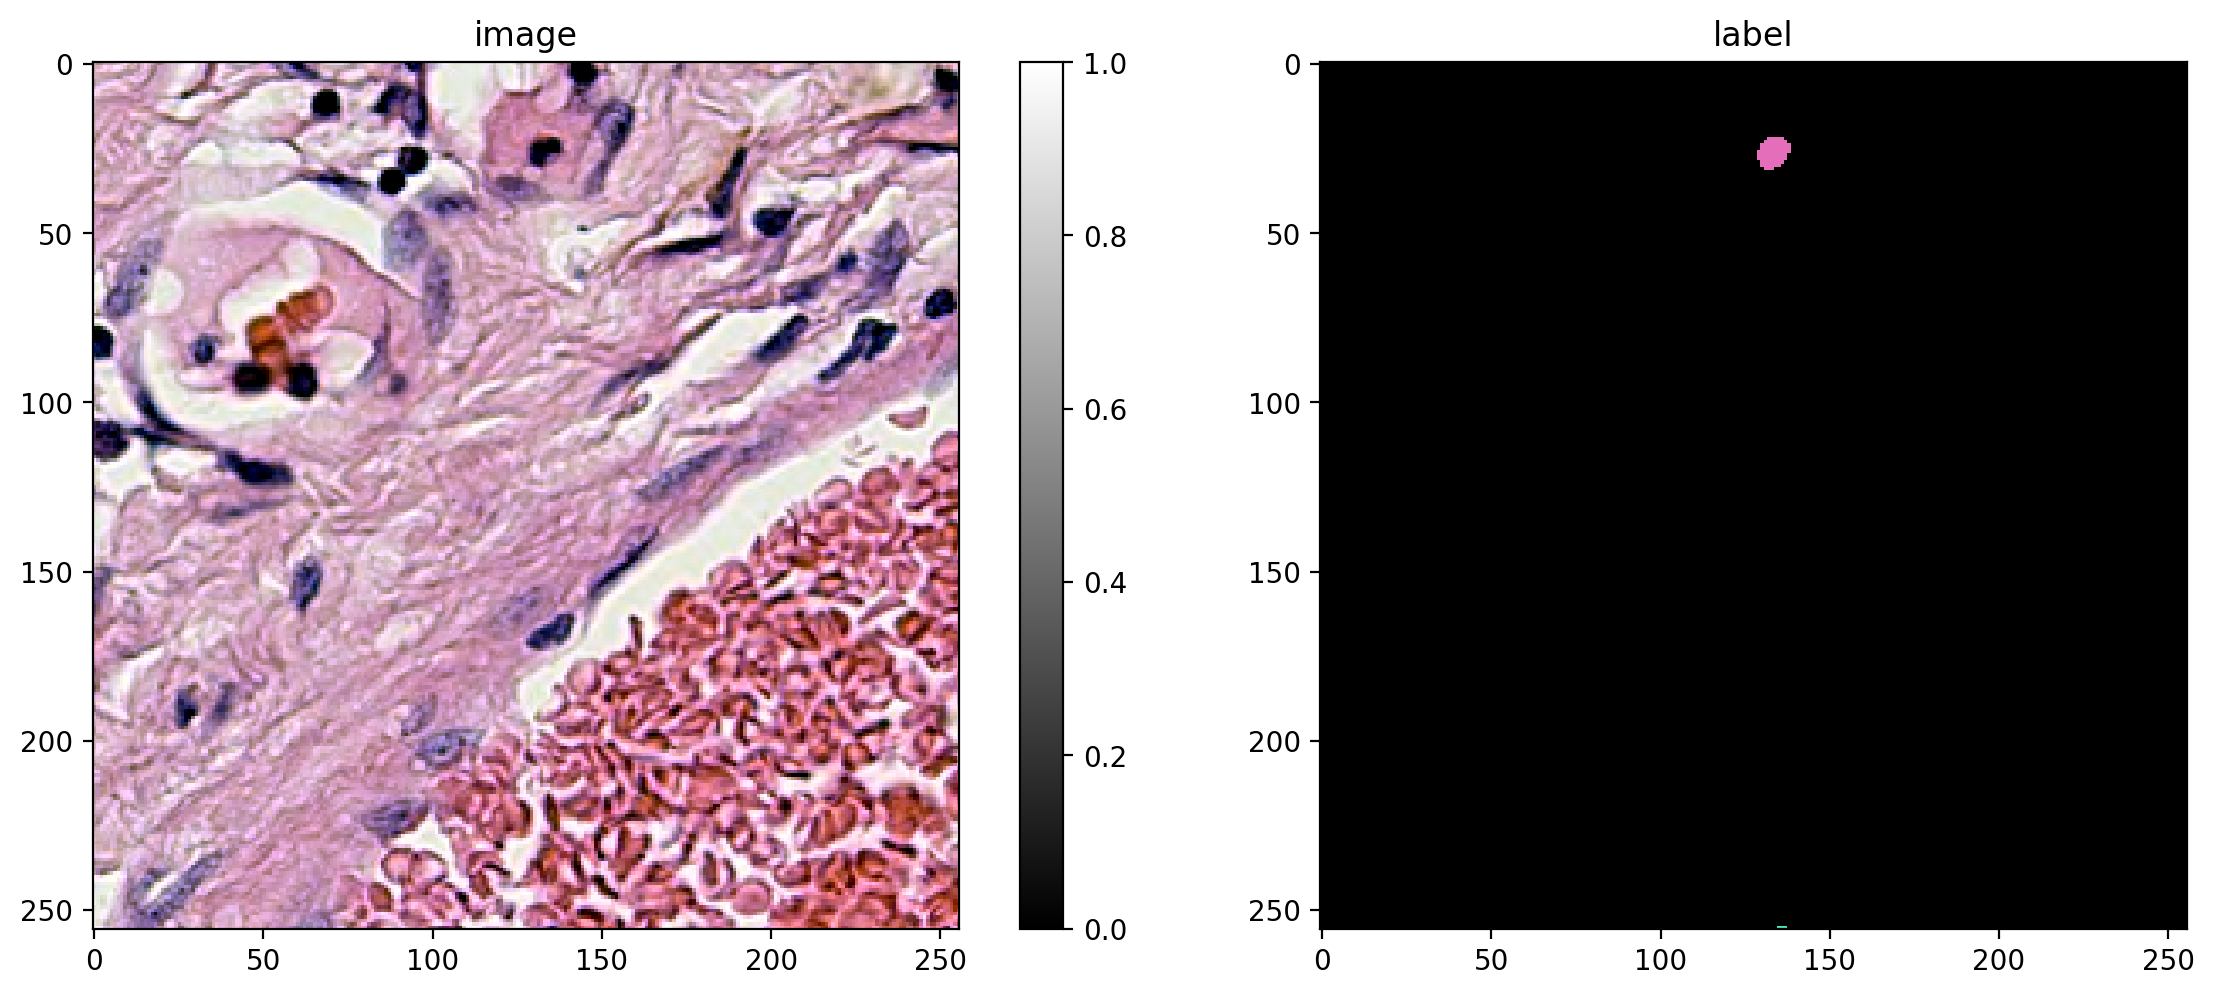

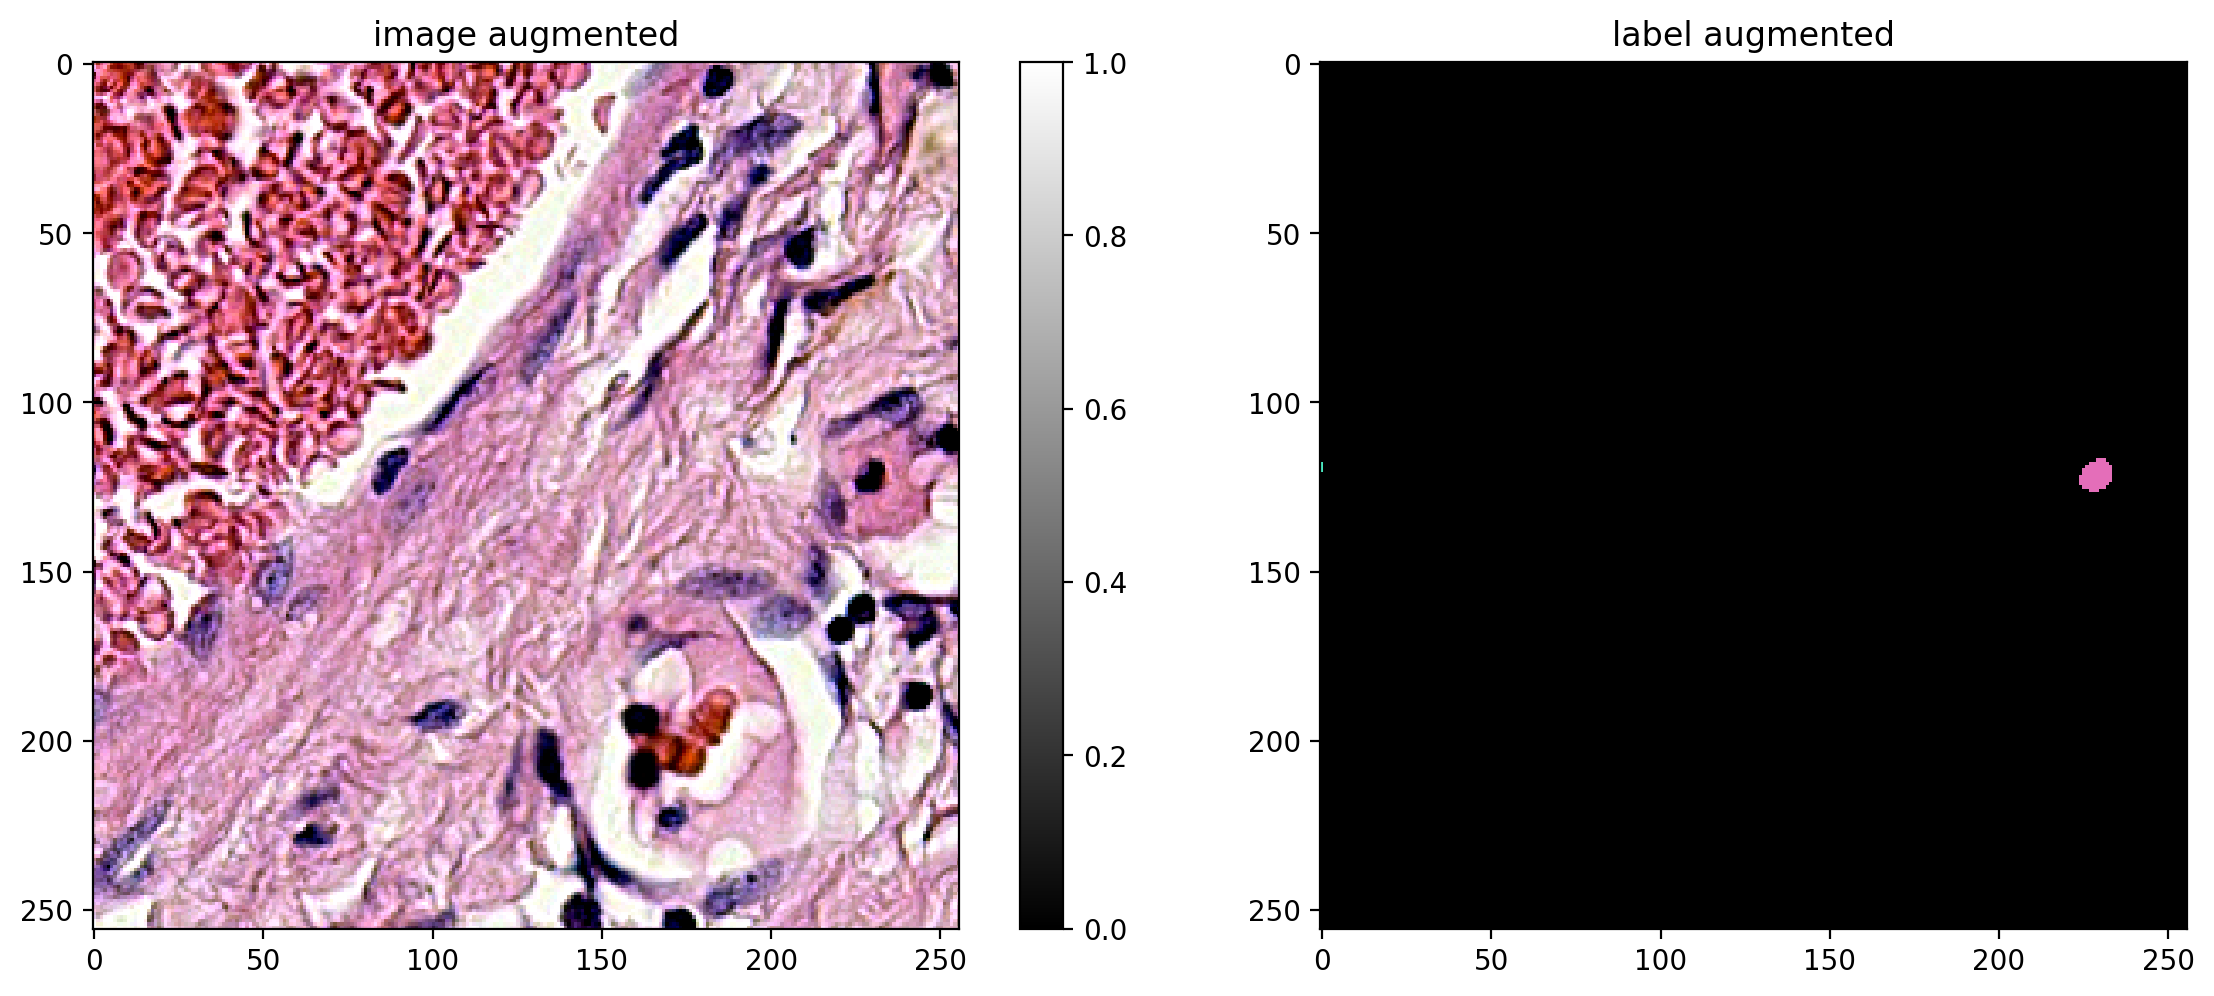

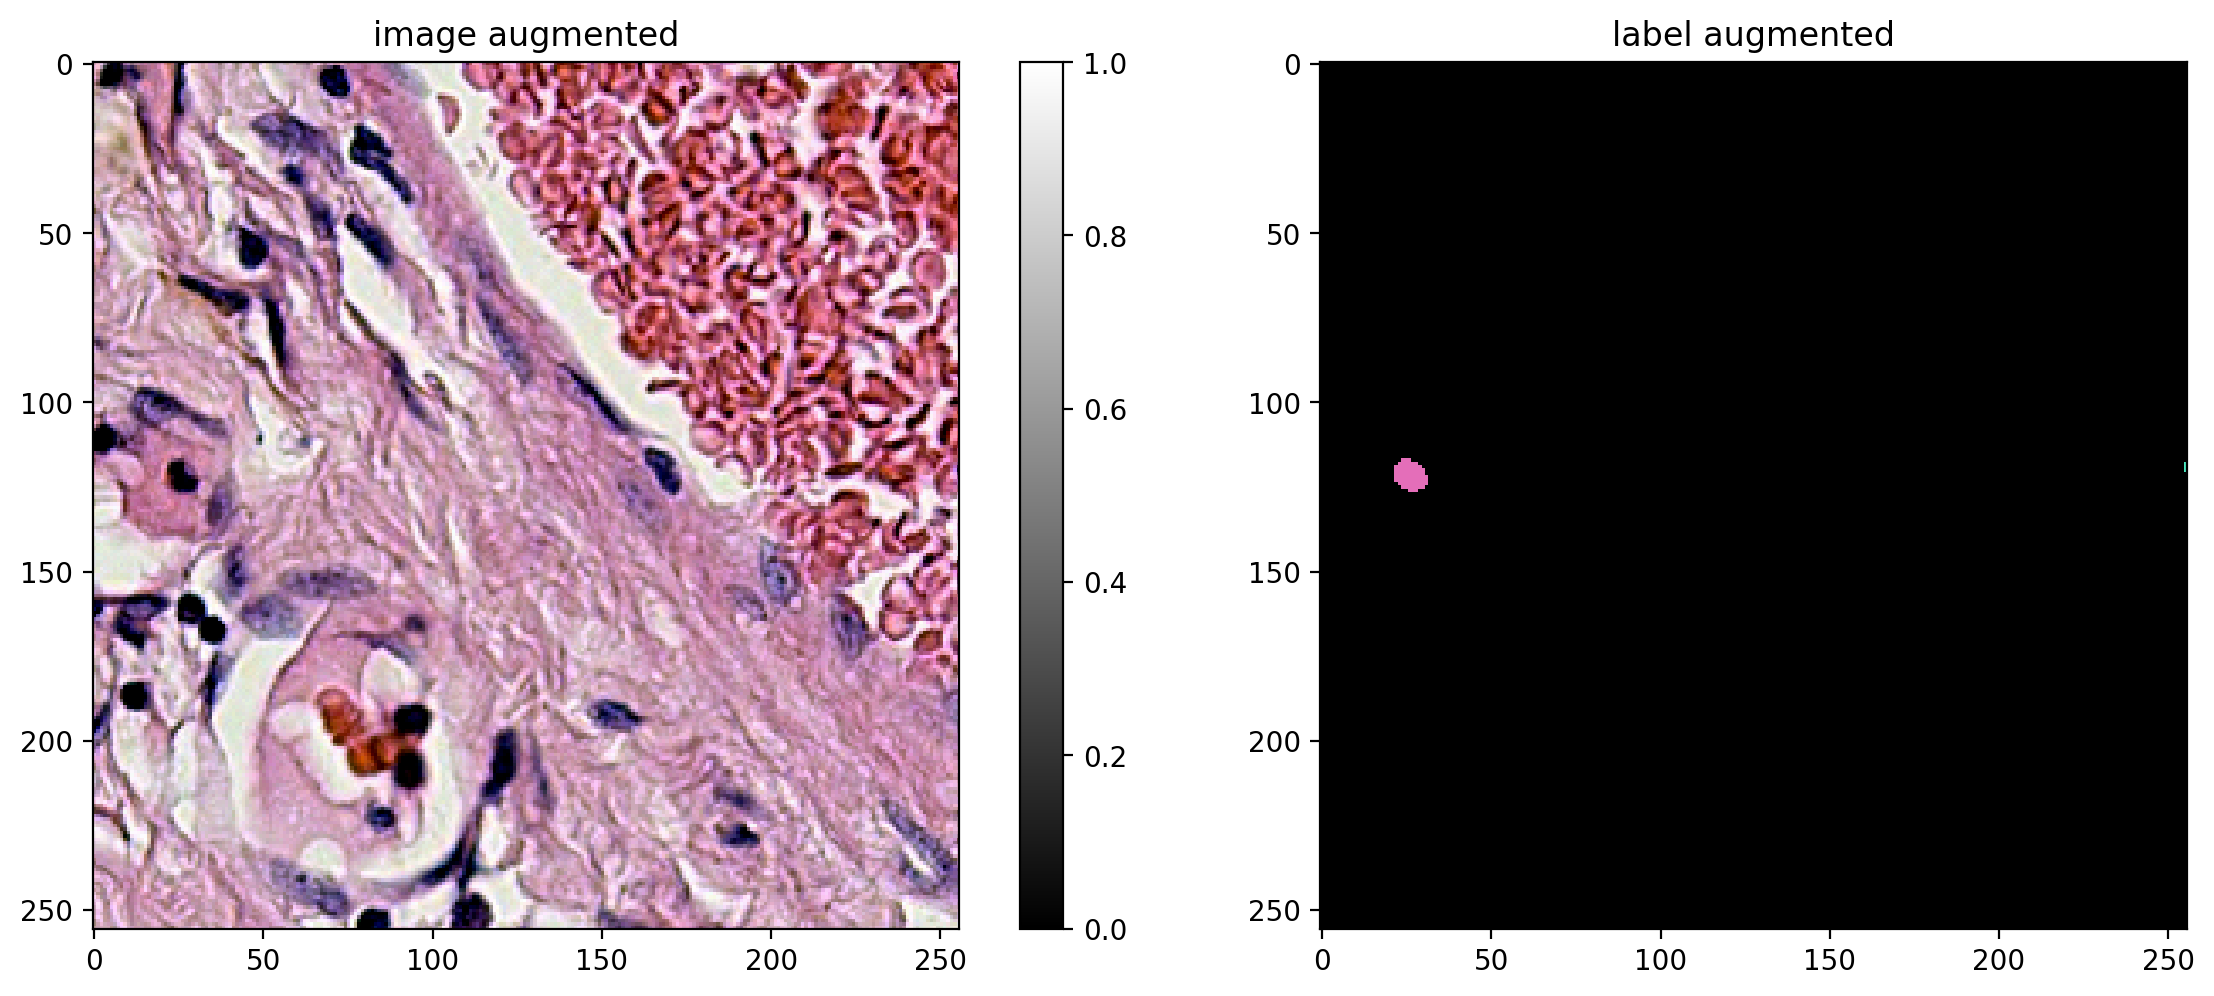

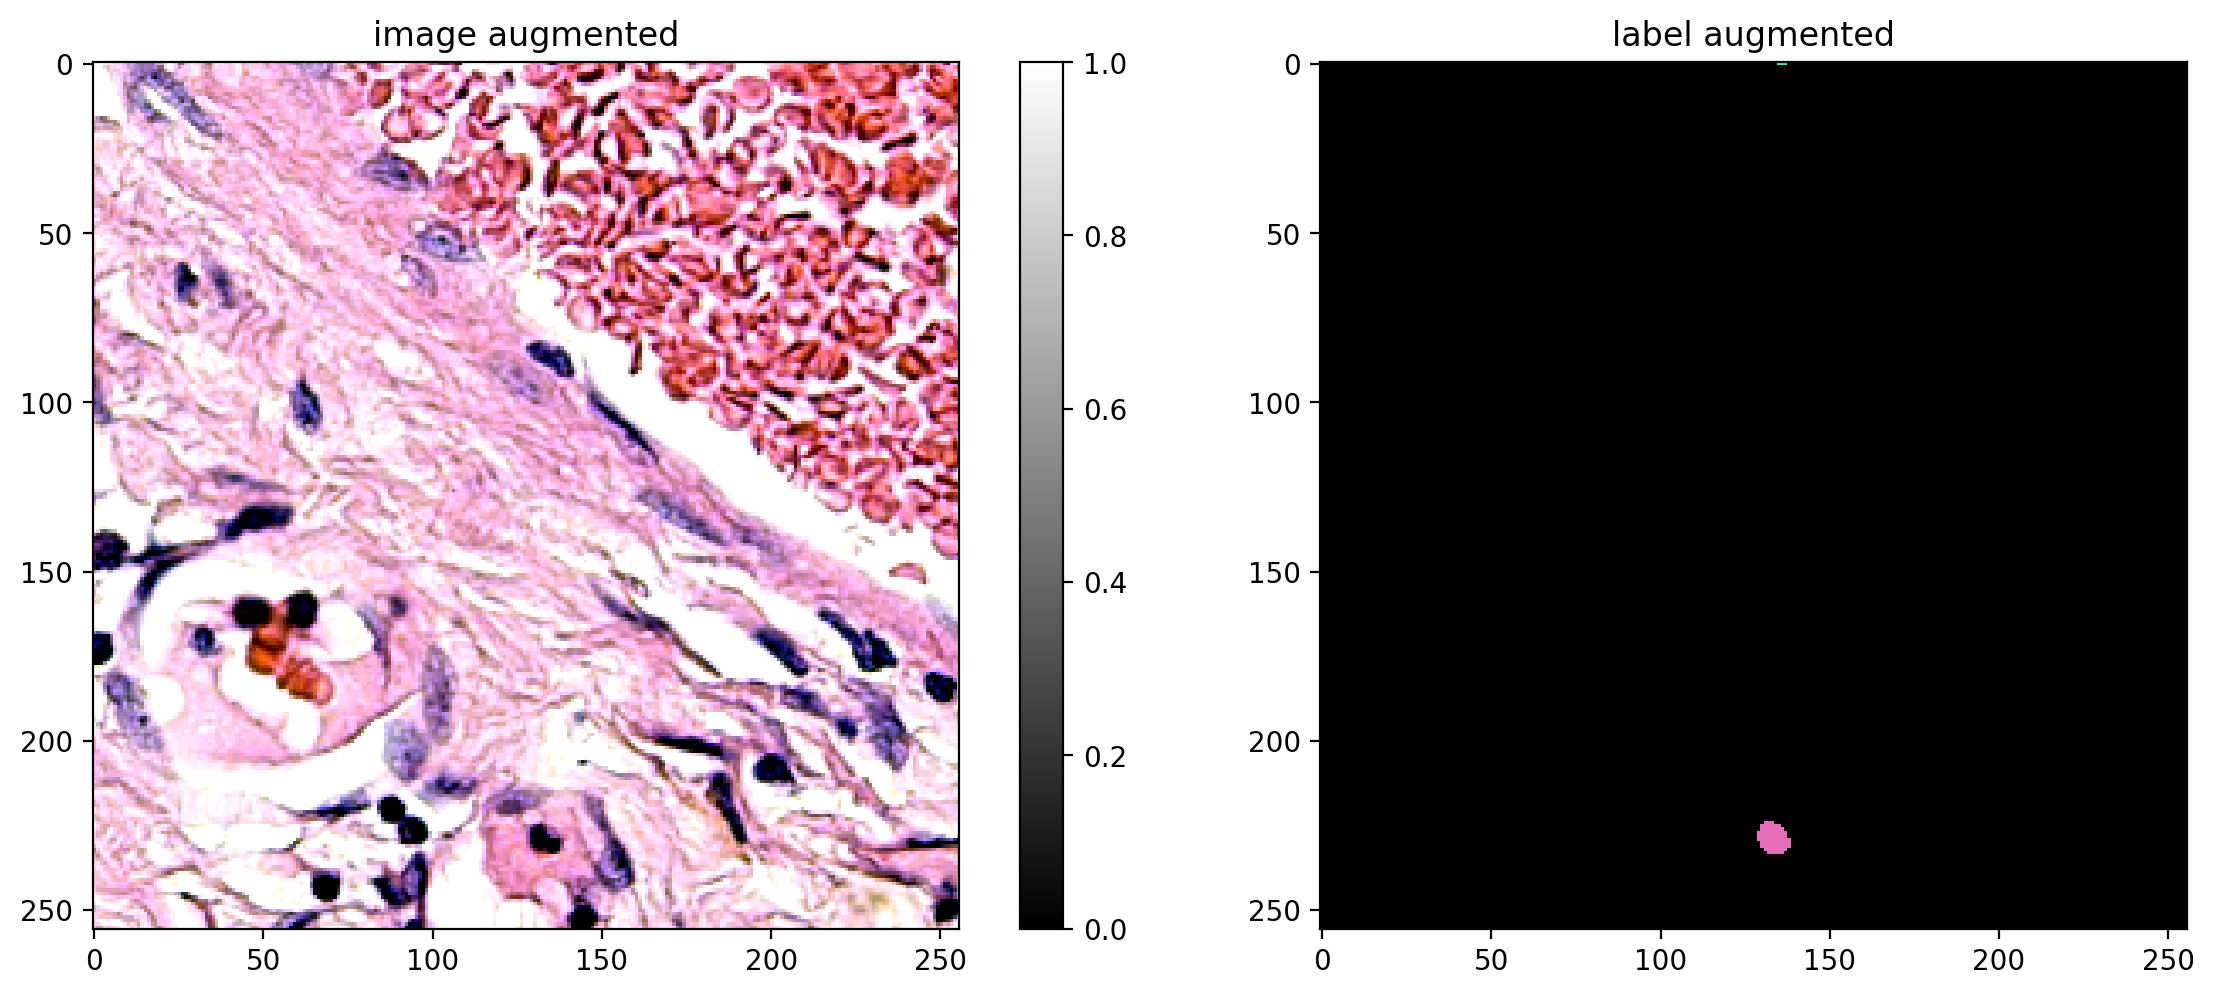

In [13]:
# plot some augmented examples
img, lbl = X_trn[0],Y_trn[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [14]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/400


2023-03-23 20:16:56.305948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Cause: Unable to locate the source code of <function _gcd_import at 0x7f4c9b4e4430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x7f4c9b4e4430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @t

2023-03-23 20:17:01.125630: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f45968a27d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-23 20:17:01.125672: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2023-03-23 20:17:01.130966: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-23 20:17:01.268318: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 16s 66ms/step - loss: 0.7159 - prob_loss: 0.0780 - dist_loss: 3.1898 - prob_kld: 0.0721 - dist_relevant_mae: 3.1895 - dist_relevant_mse: 17.2418 - dist_dist_iou_metric: 0.2062 - val_loss: 0.5481 - val_prob_loss: 0.0266 - val_dist_loss: 2.6073 - val_prob_kld: 0.0235 - val_dist_relevant_mae: 2.6070 - val_dist_relevant_mse: 11.6931 - val_dist_dist_iou_metric: 0.2267 - lr: 3.0000e-04
Epoch 2/400
100/100 [==============================] - 5s 47ms/step - loss: 0.5489 - prob_loss: 0.0266 - dist_loss: 2.6117 - prob_kld: 0.0234 - dist_relevant_mae: 2.6113 - dist_relevant_mse: 11.5174 - dist_dist_iou_metric: 0.3150 - val_loss: 0.5046 - val_prob_loss: 0.0321 - val_dist_loss: 2.3624 - val_prob_kld: 0.0289 - val_dist_relevant_mae: 2.3620 - val_dist_relevant_mse: 8.7239 - val_dist_dist_iou_metric: 0.3867 - lr: 3.0000e-04
Epoch 3/400
100/100 [==============================] - 4s 44ms/step - loss: 0.5334 - prob_loss: 0.0280 - dist_loss: 2.5270 - prob_kld: 0.0

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [15]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

1/1 [==============================] - 0s 24ms/step


NMS threshold = 0.5:  80%|████████  | 16/20 [00:03<00:00,  4.59it/s, 0.393 -> 0.187]


Using optimized values: prob_thresh=0.392095, nms_thresh=0.3.
Saving to 'thresholds.json'.


# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [31]:
# help(matching)

First predict the labels for all validation images:

In [42]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False, prob_thresh=0.2)[0]
              for x in tqdm(X_val)]

  0%|          | 0/174 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 2/174 [00:00<00:10, 16.89it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 4/174 [00:00<00:10, 16.43it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 6/174 [00:00<00:09, 16.97it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 8/174 [00:00<00:10, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 10/174 [00:00<00:11, 14.71it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 12/174 [00:00<00:10, 14.93it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 14/174 [00:00<00:10, 15.29it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 16/174 [00:01<00:11, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 18/174 [00:01<00:11, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 20/174 [00:01<00:10, 14.55it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 22/174 [00:01<00:10, 15.18it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 24/174 [00:01<00:09, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 26/174 [00:01<00:09, 15.53it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 28/174 [00:01<00:09, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 30/174 [00:01<00:09, 15.90it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 32/174 [00:02<00:08, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 34/174 [00:02<00:08, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 36/174 [00:02<00:08, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 38/174 [00:02<00:08, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 40/174 [00:02<00:08, 16.58it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 42/174 [00:02<00:08, 16.47it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 44/174 [00:02<00:07, 16.38it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 46/174 [00:02<00:07, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 48/174 [00:03<00:07, 15.89it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 50/174 [00:03<00:07, 16.13it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 52/174 [00:03<00:07, 16.12it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 54/174 [00:03<00:07, 16.49it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 56/174 [00:03<00:06, 16.95it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 58/174 [00:03<00:06, 16.95it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 60/174 [00:03<00:07, 15.97it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 62/174 [00:03<00:07, 15.13it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 64/174 [00:04<00:07, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 66/174 [00:04<00:07, 14.82it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 68/174 [00:04<00:06, 15.28it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 70/174 [00:04<00:06, 15.69it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 72/174 [00:04<00:07, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 74/174 [00:04<00:06, 14.58it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 76/174 [00:04<00:06, 15.29it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 78/174 [00:05<00:06, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 80/174 [00:05<00:06, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 82/174 [00:05<00:06, 15.33it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 84/174 [00:05<00:06, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 86/174 [00:05<00:06, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 88/174 [00:05<00:05, 14.51it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 90/174 [00:05<00:05, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 92/174 [00:05<00:05, 14.79it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 94/174 [00:06<00:05, 15.32it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 96/174 [00:06<00:04, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 98/174 [00:06<00:04, 16.00it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 100/174 [00:06<00:04, 16.21it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 102/174 [00:06<00:04, 16.30it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 104/174 [00:06<00:04, 16.51it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 106/174 [00:06<00:04, 16.66it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 108/174 [00:06<00:04, 16.19it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 110/174 [00:07<00:03, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 112/174 [00:07<00:03, 16.52it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 114/174 [00:07<00:03, 16.97it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 116/174 [00:07<00:03, 16.96it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 118/174 [00:07<00:03, 16.91it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 120/174 [00:07<00:03, 16.86it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 122/174 [00:07<00:03, 16.94it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 124/174 [00:07<00:02, 17.11it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 126/174 [00:08<00:02, 16.71it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 128/174 [00:08<00:02, 16.81it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 130/174 [00:08<00:02, 16.67it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 132/174 [00:08<00:02, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 134/174 [00:08<00:02, 16.65it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 136/174 [00:08<00:02, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 138/174 [00:08<00:02, 16.71it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 140/174 [00:08<00:02, 16.61it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 142/174 [00:08<00:01, 16.69it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 144/174 [00:09<00:01, 16.41it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 146/174 [00:09<00:01, 16.50it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 148/174 [00:09<00:01, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 150/174 [00:09<00:01, 16.52it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 152/174 [00:09<00:01, 16.18it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 154/174 [00:09<00:01, 15.87it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 156/174 [00:09<00:01, 16.30it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 158/174 [00:09<00:00, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 160/174 [00:10<00:00, 16.47it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 162/174 [00:10<00:00, 16.12it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 164/174 [00:10<00:00, 15.59it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 166/174 [00:10<00:00, 14.62it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 168/174 [00:10<00:00, 15.08it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 170/174 [00:10<00:00, 15.39it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 172/174 [00:10<00:00, 15.77it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 174/174 [00:10<00:00, 15.85it/s]


Plot a GT/prediction example 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


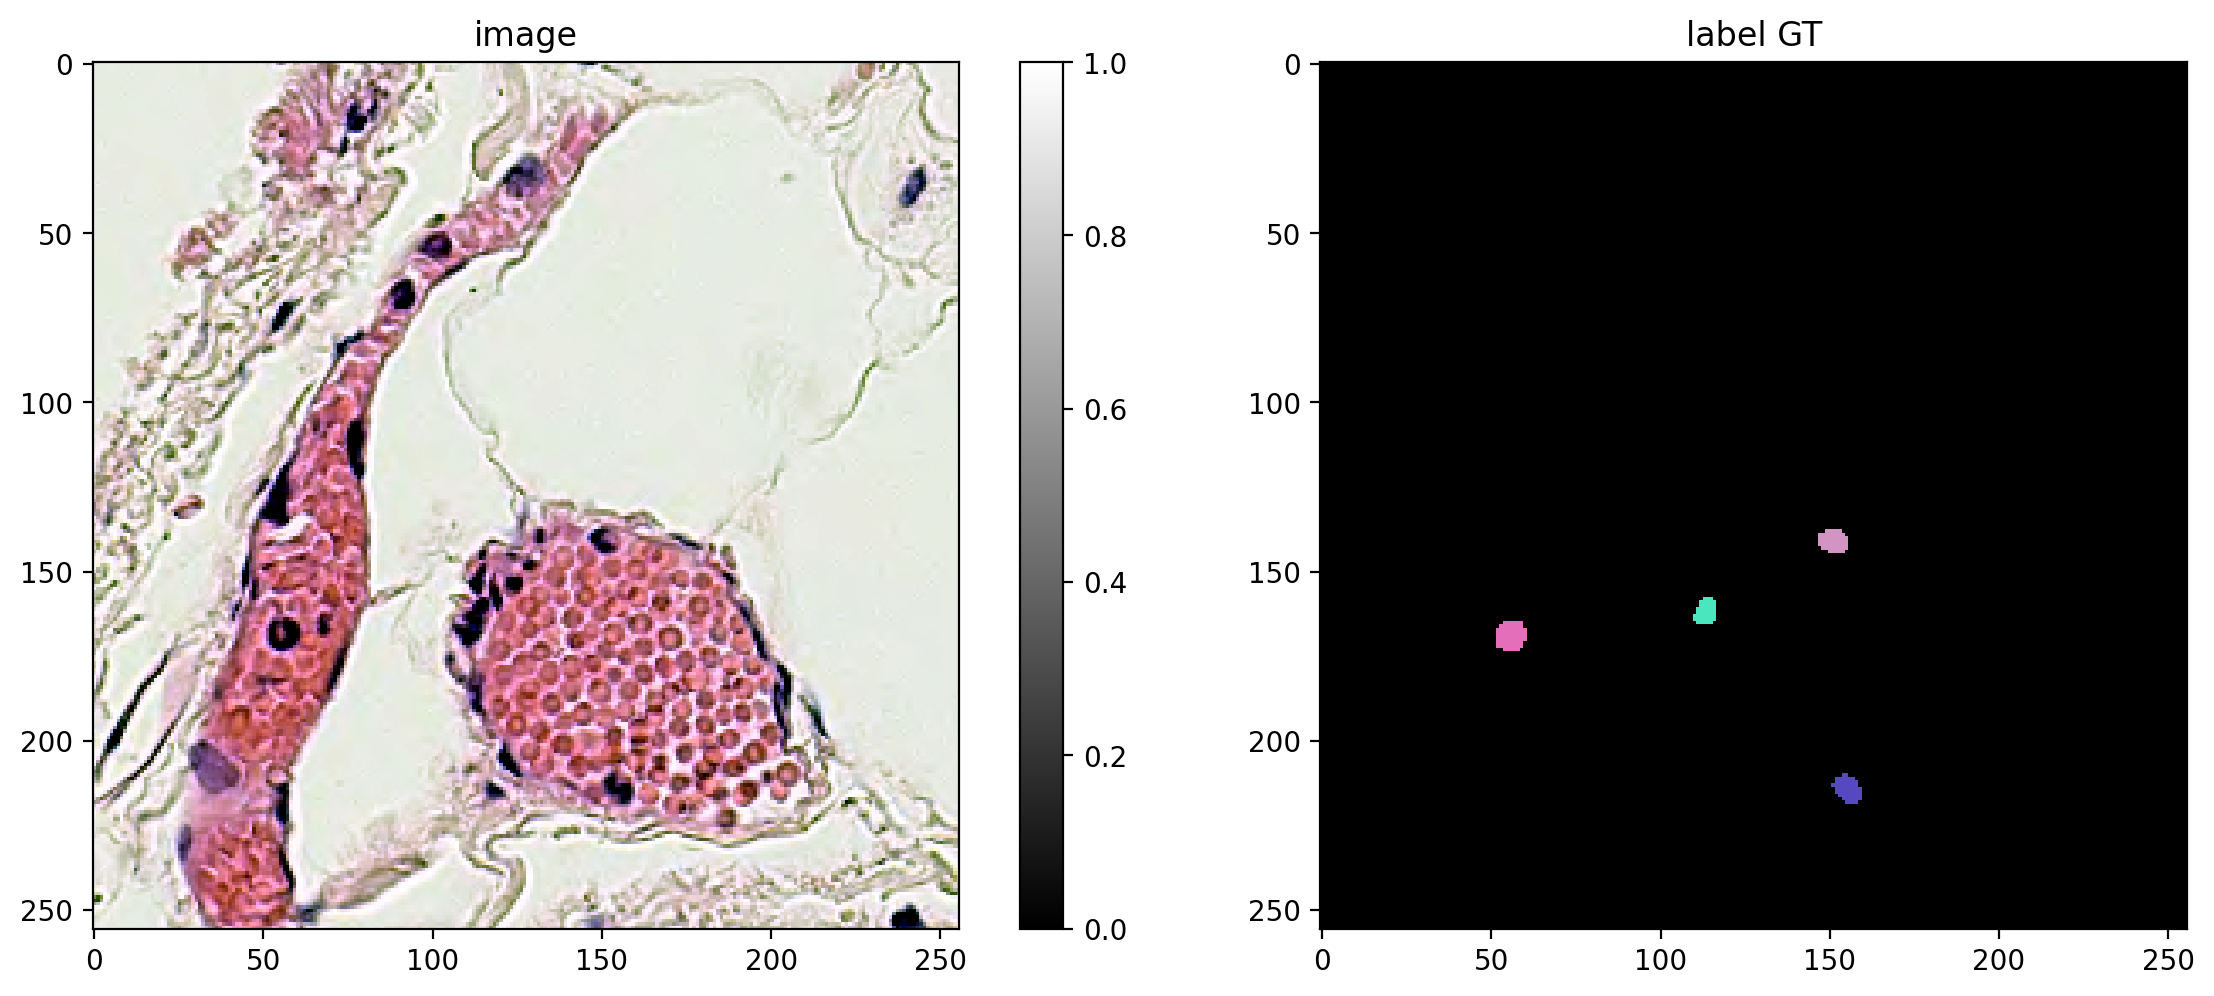

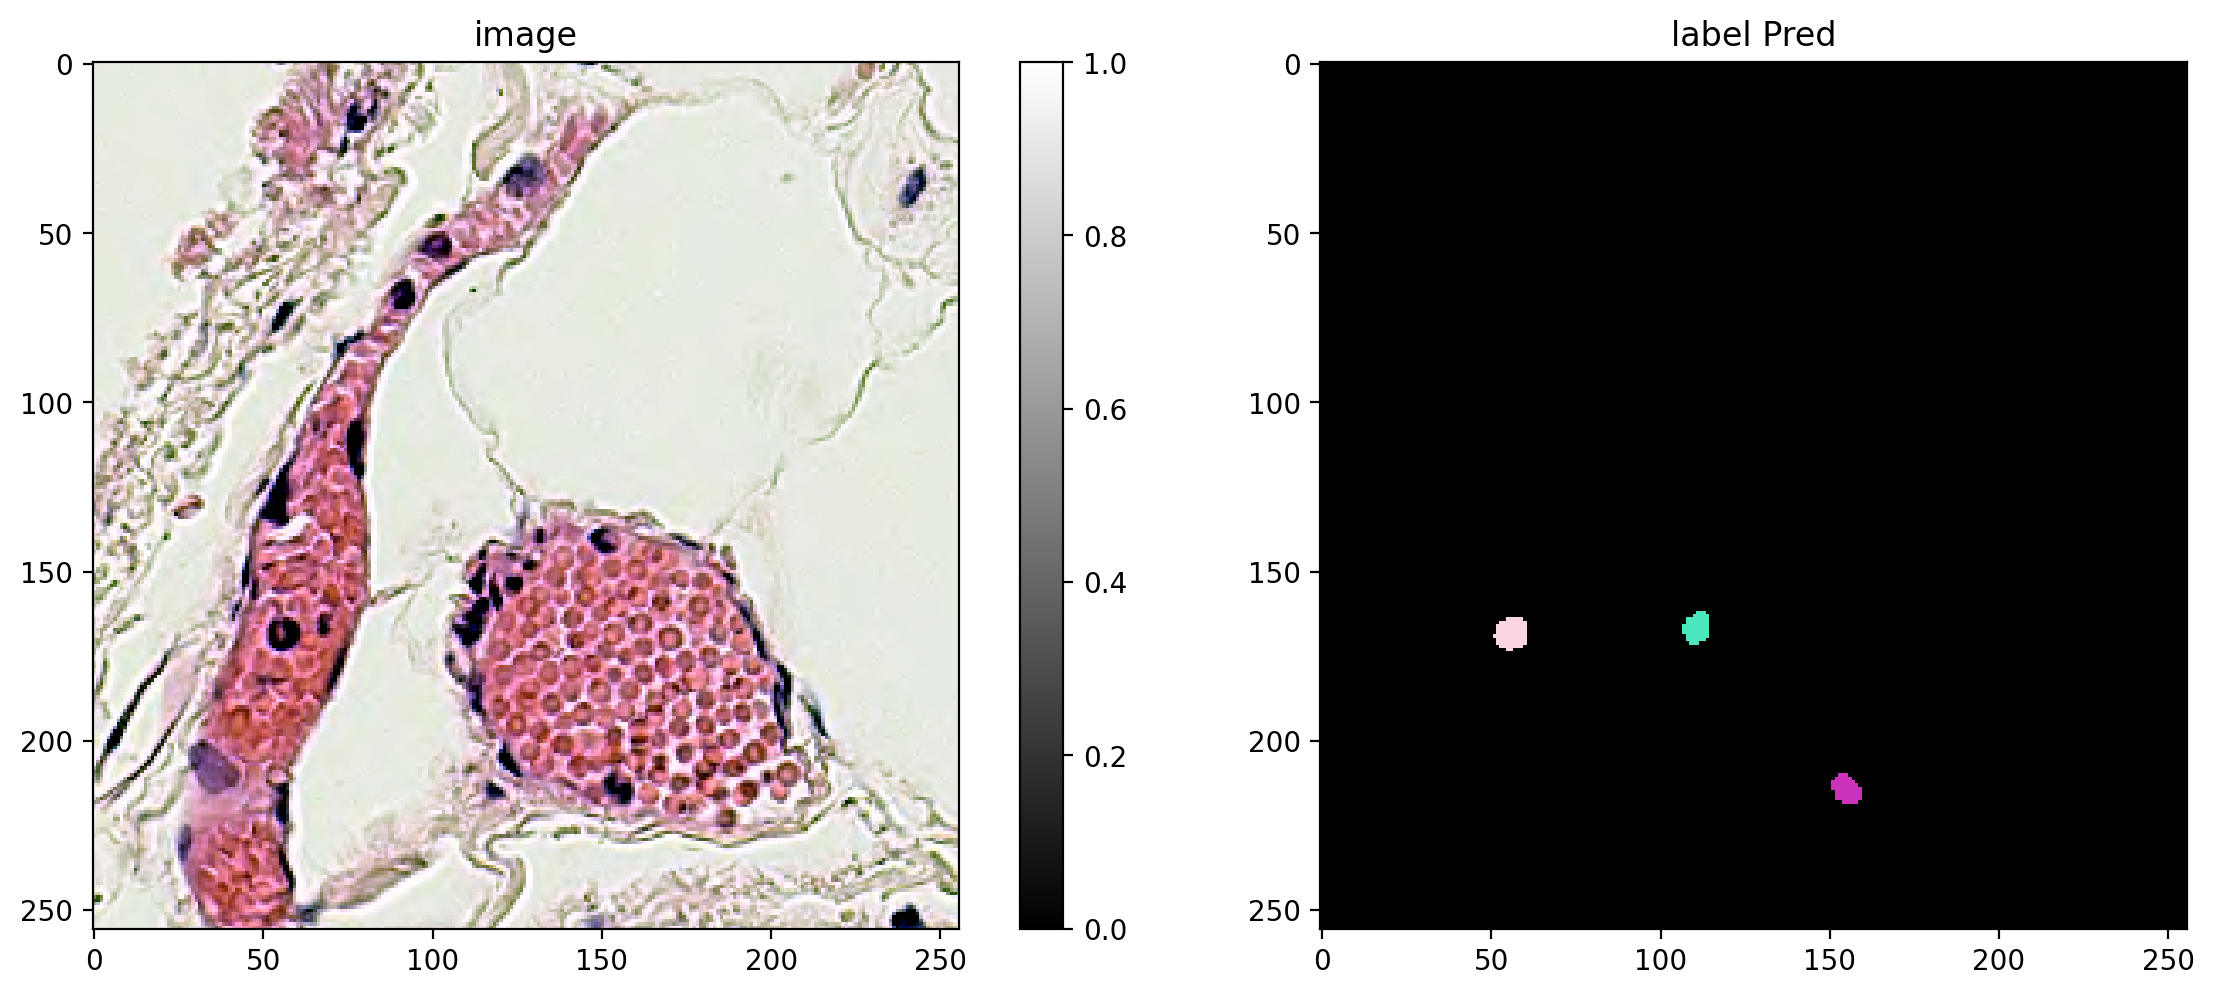

In [43]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [44]:
taus = [0.01, 0.1, 0.15, 0.2, 0.25]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


In [50]:
stats[0]

DatasetMatching(criterion='iou', thresh=0.01, fp=593, tp=440, fn=340, precision=0.4259438528557599, recall=0.5641025641025641, accuracy=0.32046613255644574, f1=0.4853833425261997, n_true=780, n_pred=1033, mean_true_score=0.4194735946515814, mean_matched_score=0.7436122814278033, panoptic_quality=0.36093701470296025, by_image=False)

Example: Print all available matching statistics for $\tau=0.5$

In [45]:
stats[taus.index(0.25)]

DatasetMatching(criterion='iou', thresh=0.25, fp=599, tp=434, fn=346, precision=0.42013552758954503, recall=0.5564102564102564, accuracy=0.3147208121827411, f1=0.47876447876447875, n_true=780, n_pred=1033, mean_true_score=0.4183664818604787, mean_matched_score=0.7519028936662981, panoptic_quality=0.35998439696764856, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

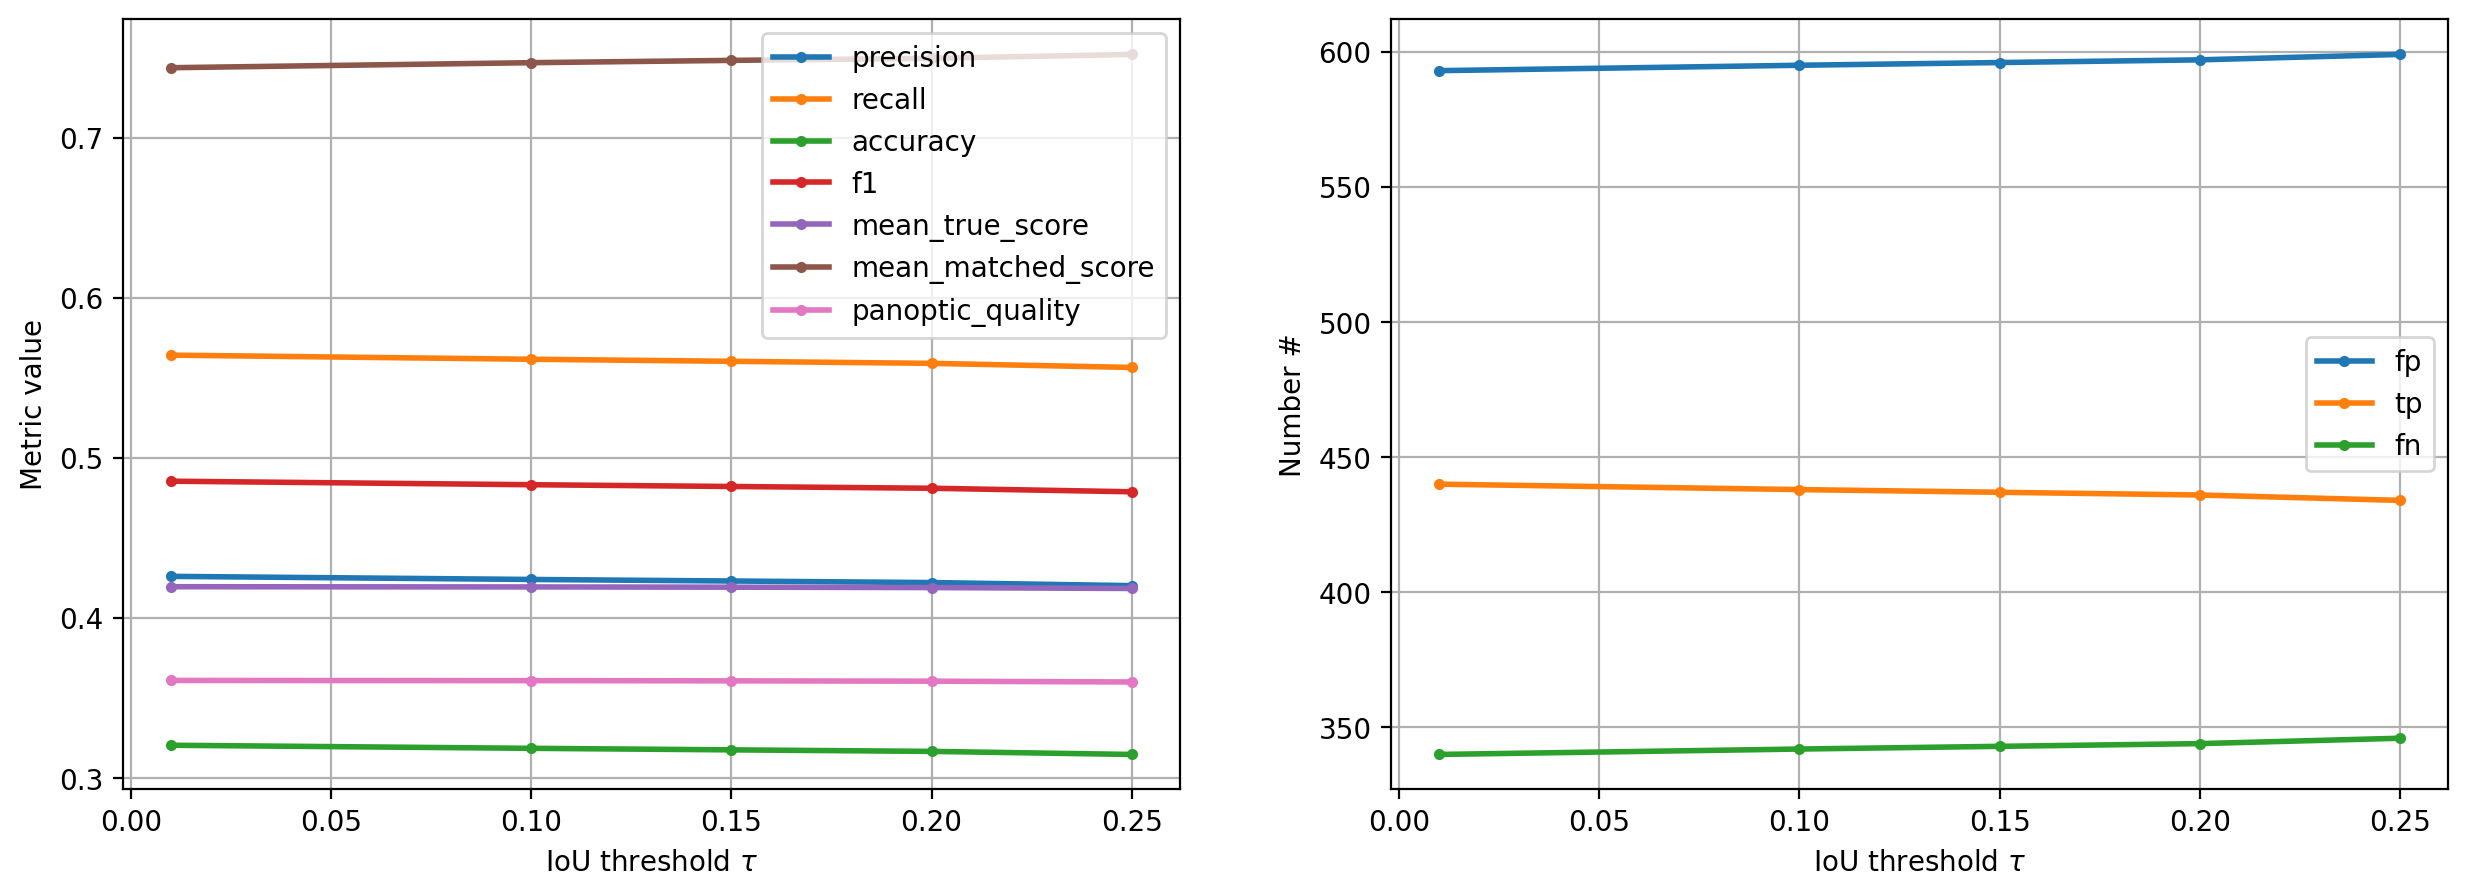

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();